Supersonic Channel at Re=3400
=================================

+ Mach = 1.5
+ Retau    =   1010.9241194
+ Rebulk   =    3400
+ Homogeneous in streamwise and spanwise directions

See:
- http://newton.dima.uniroma1.it/supchan/
- http://newton.dima.uniroma1.it/supchan/stat/CH15C.dat

How to postprocess data
-----------------------

Unlike the steady state regression tests, this case has time-varying data.  Therefore it is necessary to postprocess the saved fields to get the data needed for validation.

The steps to produce the post-processed data is listed in the post-processing repo, in the `channel_HM` folder, in the `README.md` file.  Once the post-processed data is generated, it can be copied over to the `SU2_data` directory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
plt.style.use(('seaborn-notebook'))

In [2]:
def plot_log_layer_indicator(SU2, DNS, beta_DNS):
    hybrid_iterations = SU2["iterations"][1:]
    fig, ax = plt.subplots()
    x_limits = [30, 5200]
    rescaled_iterations = (np.array(hybrid_iterations) - hybrid_iterations[0])/(hybrid_iterations[-1] - hybrid_iterations[0])
    ax.set_prop_cycle('color', plt.cm.cool(rescaled_iterations))
    for i in range(len(hybrid_iterations)):
        time_label = "$t = {:.1f}$".format(SU2["time"][i+1])
        ax.plot(SU2["yplus"], SU2["beta"][i+1, :], label=time_label, linewidth=1, alpha=0.3)
    ax.set_prop_cycle(None)
    ax.plot(SU2["yplus"], SU2["beta"][0, :], label="RANS")
    ax.plot(SU2["yplus"], SU2["mean_beta"], label="mean")
    ax.plot(x_limits, 1.0/0.4 * np.ones(2), "--", label="$1/\\kappa$")
    ax.plot(DNS_mean["yplus"], beta_DNS, label="DNS")
    ax.set_xlim(x_limits)
    ax.set_xscale("log")
    ax.set_ylim([2, 4])
    ax.set_ylabel("$\\frac{1}{y^+} \\frac{\partial u^+}{\partial y^+}$")
    ax.set_xlabel("$y+$")
    ax.legend(loc="best")
    fig.set_size_inches(10, 5)
    fig.tight_layout()
    return fig, ax

Extract Data
------------

In [3]:
iterations = np.arange(10000, 20250, 250)
# Note: If the dimensional timestep is from SU2, then the dimensional
# length and dimensional bulk velocity must also be from SU2
L = 2*np.pi
U_b = 491.8753701144353
flow_through_time = L/U_b
timestep = 4E-5
nondim_times = [(it - iterations[0])*timestep*U_b/L for it in iterations]
dx = 2*np.pi/50
CFL = timestep*U_b/dx
print(CFL)

0.15656879307773583


In [4]:
names = ['y', 'yplus', 'y_H', 'u', 'u_D', 'u_T', 'urms', 'vrms', 'wrms', 'R12', 'T']
columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]
DNS = np.genfromtxt("DNS_data/CH15C.dat", skip_header=18, usecols=columns, names=names)
DNS_k = 0.5*(DNS['urms']**2 + DNS['vrms']**2 + DNS['wrms']**2)
beta_DNS = DNS["yplus"]*np.gradient(DNS["u_D"], DNS["yplus"])
beta2_DNS = DNS["yplus"]*np.gradient(DNS["u_T"], DNS["y_H"])

In [5]:
commits = ['c2c49e4', 'f18dcf7']

In [6]:
SU2_data = {}
for commit in commits:
    infile = "SU2_data/{}_results.hdf5".format(commit)
    SU2_data[commit] = h5py.File(infile, "r")

In [7]:
print(SU2_data[commits[0]].attrs.keys())
print(SU2_data[commits[0]].keys())
print(SU2_data[commits[0]]["profiles"].keys())
print(SU2_data[commits[0]]["profiles"]["T"].dtype.names)

<KeysViewHDF5 ['M_b', 'M_t', 'Re_b', 'SU2 commit', 'T_b', 'cfg file', 'dimensional bulk velocity', 'dimensional domain length', 'nondim timestep', 'rho_b', 'rhou_b', 'u_b', 'u_c', 'u_t']>
<KeysViewHDF5 ['iterations', 'mean beta', 'profiles', 'time', 'y', 'yplus']>
<KeysViewHDF5 ['F_diff', 'F_mag', 'T', 'TKE', 'alpha', 'avgF_mag', 'beta', 'r_M', 'u']>
('mean', 'median', 'std', 'p75', 'p25', 'min', 'max')


In [8]:
# We assume that all the runs have the same timesteps, etc.
iterations = SU2_data[commits[0]]["iterations"]
L = SU2_data[commits[0]].attrs["dimensional domain length"]
U_b = SU2_data[commits[0]].attrs["dimensional bulk velocity"]
nondim_timestep = SU2_data[commits[0]].attrs["nondim timestep"]
nondim_times = SU2_data[commits[0]]["time"]
dx = 2*np.pi/50
CFL = nondim_timestep * dx/L
print(CFL)

6.262751723109433e-05


In [9]:
stationary_row = np.argmin(np.abs(iterations[:] - 16000))
stationary_times = nondim_times[stationary_row:]
stationary_label = "Average of {:.1f} to {:.1f} flow-throughs".format(stationary_times[0], stationary_times[-1])
print(stationary_label)

Average of 18.8 to 31.3 flow-throughs


In [10]:
SU2_stats = {}
for commit in commits:
    SU2_stats[commit] = {}
    SU2_stats[commit]["mean"] = {}
    SU2_stats[commit]["std"] = {}
    for var_key in SU2_data[commit]["profiles"].keys():
        if var_key == "beta":
            data = SU2_data[commit]["profiles"][var_key]
        else:
            data = SU2_data[commit]["profiles"][var_key]["mean"]
        # Axis 0 corresponds to the iteration, axis 1 corresponds to y location
        SU2_stats[commit]["mean"][var_key] = np.mean(data[stationary_row:,:], axis=0)
        SU2_stats[commit]["std"][var_key] = np.std(data[stationary_row:,:], axis=0)

Mean Velocity
-------------

In [11]:
xlimits = [0.5, np.max(DNS['yplus'])]

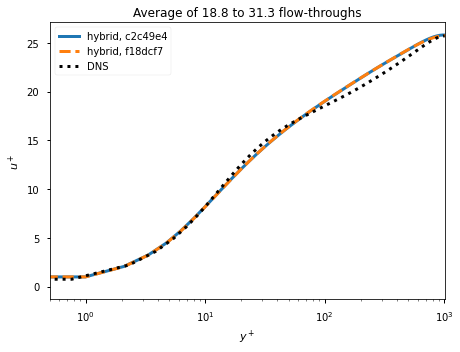

In [12]:
symbols = ["-", "--", ":"]
fig, ax = plt.subplots()
for commit, symbol in zip(commits, symbols): 
    ax.semilogx(SU2_data[commit]["yplus"], SU2_stats[commit]["mean"]["u"],
                symbol, label=("hybrid, " + commit), linewidth=3)
ax.semilogx(DNS["yplus"], DNS["u"], ":k", label="DNS", linewidth=3)
ax.legend(loc="best")
ax.set_xlim(xlimits)
ax.set_ylabel("$u^+$")
ax.set_xlabel("$y^+$")
ax.set_title(stationary_label)
fig.set_size_inches([6.5, 5])
fig.tight_layout()
fig.savefig("highmach_uplus.pdf", transparent=True)

## Mean Temperature

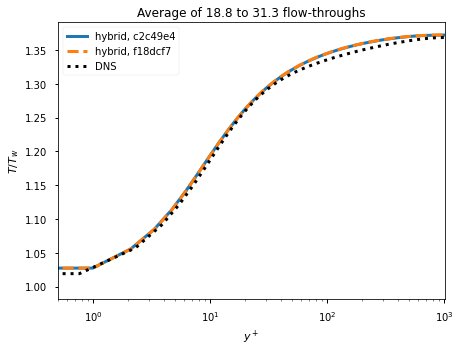

In [13]:
symbols = ["-", "--", ":"]
fig, ax = plt.subplots()
for commit, symbol in zip(commits, symbols): 
    ax.semilogx(SU2_data[commit]["yplus"], SU2_stats[commit]["mean"]["T"],
                symbol, label=("hybrid, " + commit), linewidth=3)
ax.semilogx(DNS["yplus"], DNS["T"], ":k", label="DNS", linewidth=3)
ax.legend(loc="best")
ax.set_xlim(xlimits)
ax.set_ylabel("$T/T_w$")
ax.set_xlabel("$y^+$")
ax.set_title(stationary_label)
fig.set_size_inches([6.5, 5])
fig.tight_layout()
fig.savefig("highmach_uplus.pdf", transparent=True)

Log-Layer Indicator
-------------------

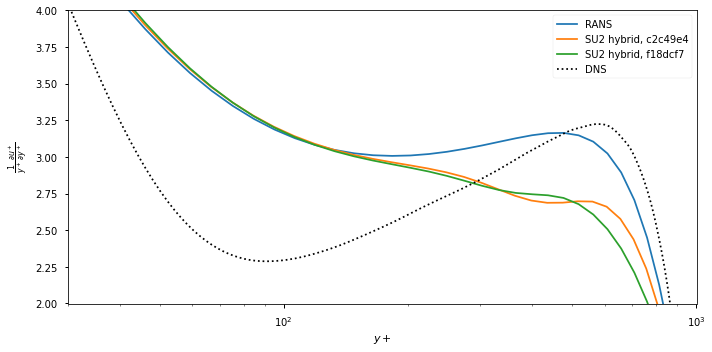

In [14]:
fig, ax = plt.subplots()
ax.plot(SU2_data[commit]["yplus"], SU2_data[commit]["profiles"]["beta"][0, :], label="RANS")
for commit in commits:
    label = "SU2 hybrid, " + commit
    ax.plot(SU2_data[commit]["yplus"], SU2_data[commit]["mean beta"], label=label)
ax.plot(DNS["yplus"], beta_DNS, "k:", label="DNS")
ax.set_xlim([30, np.max(DNS['yplus'])])
ax.set_xscale("log")
ax.set_ylim([2, 4])
ax.set_ylabel("$\\frac{1}{y^+} \\frac{\partial u^+}{\partial y^+}$")
ax.set_xlabel("$y+$")
ax.legend(loc="best")
fig.set_size_inches(10, 5)
fig.tight_layout()
fig.savefig("highmach_log_layer.pdf", transparent=True)

TKE
---

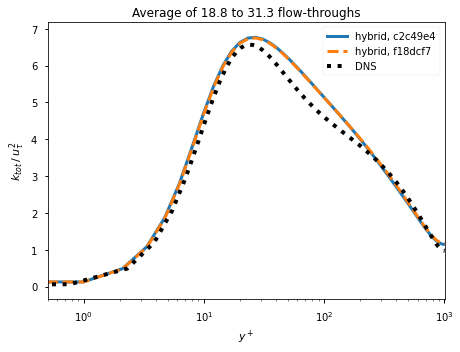

In [15]:
fig, ax = plt.subplots()
for commit, symbol in zip(commits, symbols): 
    ax.semilogx(SU2_data[commit]["yplus"], SU2_stats[commit]["mean"]["TKE"],
                symbol, label=("hybrid, " + commit), linewidth=3)
ax.semilogx(DNS["yplus"], DNS_k, ":k", label="DNS", linewidth=4)
ax.legend(loc="best")
ax.set_xlim(xlimits)
ax.set_ylabel("$k_{tot}\:/\:u_{\\tau}^2$")
ax.set_xlabel("$y^+$")
ax.set_title(stationary_label)
fig.set_size_inches([6.5, 5])
fig.tight_layout()
fig.savefig("highmach_tke.pdf", transparent=True)

Alpha
-----

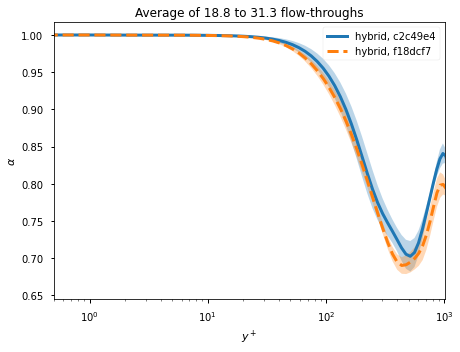

In [16]:
fig, ax = plt.subplots()
for commit, symbol in zip(commits, symbols): 
    ax.semilogx(SU2_data[commit]["yplus"], SU2_stats[commit]["mean"]["alpha"],
                symbol, label=("hybrid, " + commit), linewidth=3)
    upper_limit = SU2_stats[commit]["mean"]["alpha"] + SU2_stats[commit]["std"]["alpha"]
    lower_limit = SU2_stats[commit]["mean"]["alpha"] - SU2_stats[commit]["std"]["alpha"]
    ax.fill_between(SU2_data[commit]["yplus"], lower_limit, upper_limit, alpha=0.3)
ax.legend(loc="best")
ax.set_xlim(xlimits)
ax.set_ylabel("$\\alpha$")
ax.set_xlabel("$y^+$")
ax.set_title(stationary_label)
fig.set_size_inches([6.5, 5])
fig.tight_layout()
fig.savefig("highmach_alpha.pdf", transparent=True)

Time Evolution
--------------

In [17]:
y_indices = [35, 50]

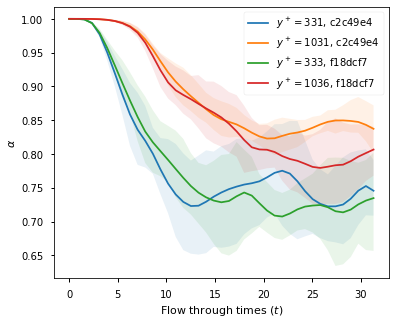

In [18]:
fig, ax = plt.subplots()
for commit in commits:
    profiles = SU2_data[commit]["profiles"]
    for y_index in y_indices:
        y_loc = SU2_data[commit]["yplus"][y_index]
        label="$y^+ = {:.0f}$, {}".format(y_loc, commit)
        ax.plot(SU2_data[commit]["time"], profiles["alpha"]["mean"][:, y_index], label=label)
        ax.fill_between(SU2_data[commit]["time"], profiles["alpha"]["p75"][:, y_index],
                        profiles["alpha"]["p25"][:, y_index], alpha=0.1)
ax.legend(loc="best")
ax.set_xlabel("Flow through times ($t$)")
ax.set_ylabel("$\\alpha$")
fig.set_size_inches(6, 5)
plt.show()

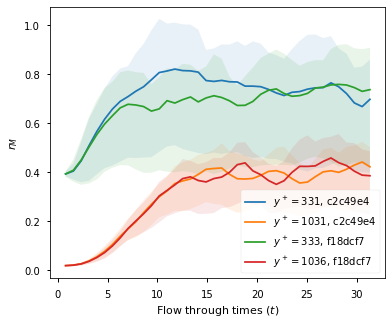

In [19]:
fig, ax = plt.subplots()
for commit in commits:
    profiles = SU2_data[commit]["profiles"]
    for y_index in y_indices:
        y_loc = SU2_data[commit]["yplus"][y_index]
        label="$y^+ = {:.0f}$, {}".format(y_loc, commit)
        ax.plot(SU2_data[commit]["time"][1:], profiles["r_M"]["mean"][1:, y_index], label=label)
        ax.fill_between(SU2_data[commit]["time"][1:], profiles["r_M"]["p75"][1:, y_index],
                        profiles["r_M"]["p25"][1:, y_index], alpha=0.1)
ax.legend(loc="best")
ax.set_xlabel("Flow through times ($t$)")
ax.set_ylabel("$r_M$")
fig.set_size_inches(6, 5)
plt.show()

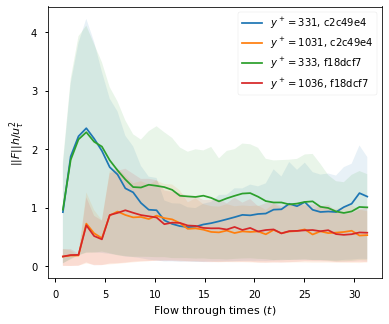

In [20]:
fig, ax = plt.subplots()
for commit in commits:
    profiles = SU2_data[commit]["profiles"]
    for y_index in y_indices:
        y_loc = SU2_data[commit]["yplus"][y_index]
        label="$y^+ = {:.0f}$, {}".format(y_loc, commit)
        ax.plot(SU2_data[commit]["time"][1:], profiles["F_diff"]["mean"][1:, y_index], label=label)
        ax.fill_between(SU2_data[commit]["time"][1:], profiles["F_diff"]["p75"][1:, y_index],
                        profiles["F_diff"]["p25"][1:, y_index], alpha=0.1)
ax.legend(loc="best")
ax.set_xlabel("Flow through times ($t$)")
ax.set_ylabel("$||F||h/u_{\\tau}^2$")
fig.set_size_inches(6, 5)
plt.show()